# Libraries

In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.signal import detrend
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from __future__ import absolute_import, print_function

from neuroCombat import neuroCombat
from neuroCombat import neuroCombatFromTraining
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Directories

In [2]:
ROOT = Path().resolve().parent      # one level up from current dir
fmri_df = pd.read_excel(ROOT / "data/Simultaneous_PET_fMRI/fmri_results.xlsx")
pet_df = pd.read_excel(ROOT / "data/Simultaneous_PET_fMRI/pet_results.xlsx")
pet_LONG_df = pd.read_excel(ROOT / "data/Simultaneous_PET_fMRI/pet_results_with_timecourse.xlsx")
timeseries_Panel_A_df = pd.read_csv(ROOT / "data/Simultaneous_PET_fMRI/all_timeseries_Panel_A.csv")
timeseries_df = pd.read_csv(ROOT / "data/Simultaneous_PET_fMRI/all_timeseries.csv")
timeseries_undetrended_df = pd.read_csv(ROOT / "data/Simultaneous_PET_fMRI/all_timeseries_undetrended_pfi.csv")

# Set Tick Size

In [3]:
sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Prep the dataframes

In [4]:
fmri = fmri_df
pet = pet_df  
pet_LONG = pet_LONG_df
all_timeseries_Panel_A = timeseries_Panel_A_df
all_timeseries = timeseries_df
all_timeseries_undetrended = timeseries_undetrended_df

# Prep the dataframes - filter data

In [5]:
# Define a functio to split the table in first session and both sessions
def extract_last_digit_and_filter(df):
    # Extract the last digit of the 'subID' column
    df['session'] = df['subID'].astype(str).str[-1]
    
    # Convert the last digit to integer type
    df['session'] = df['session'].astype(int)
    
    # Create a new DataFrame with rows where 'session' equals 1
    original_name_first_session = df[df['session'] == 1].copy()
    
    return original_name_first_session


pd.set_option('display.max_rows', None)



# Merge the dataframes
fmri_first_session = extract_last_digit_and_filter(fmri)

# Extract the first number after 'sub-' and classify
fmri_first_session['sub_id_categorical'] = fmri_first_session['subID'].apply(
    lambda x: 1 if x.split('-')[1].startswith('1') else 0
)

fmri_first_session['group'] = fmri_first_session['subID'].apply(
    lambda x: 'Patient' if x.split('-')[1].startswith('1') else 'Healthy Control'
)

hc_fmri_first_session = fmri_first_session[(fmri_first_session['sub_id_categorical'] == 0)]

# Concatenating all the data into one big dataframe
bimodal = pd.merge(fmri,pet,on='subID',how='inner')
bimodal = bimodal.dropna(subset=['subID'])

# Extract the first number after 'sub-' and classify
bimodal['sub_id_categorical'] = bimodal['subID'].apply(
    lambda x: 1 if x.split('-')[1].startswith('1') else 0
)

bimodal['group'] = bimodal['subID'].apply(
    lambda x: 'Patient' if x.split('-')[1].startswith('1') else 'Healthy Control'
)

# Defining healthy and patient group: fMRI and PET
#bimodal['sub_id_categorical'] = bimodal['subject'].apply(lambda x: 0 if x.startswith('C') else 1)
#bimodal['group'] = bimodal['subject'].apply(lambda x: "Healthy Control" if x.startswith('C') else "Patient")
bimodal_first_session = extract_last_digit_and_filter(bimodal)
hc_bimodal = bimodal[(bimodal['sub_id_categorical'] == 0)]
hc_bimodal_first_session = extract_last_digit_and_filter(hc_bimodal)


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_2618/3055318069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session'] = df['subID'].astype(str).str[-1]
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_2618/3055318069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session'] = df['session'].astype(int)


# Initialize the plotting settings - Monokai Pro

In [6]:
# SETTING MONOKAI PRO AS COLOR SCHEME
monokai_pro_palette_tri = [
    (249, 38, 114),   # Red
    (102, 217, 239),  # Blue
    (174, 129, 255),  # Purple
]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_tri = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_tri]


monokai_pro_palette_tfi = [
    (204, 237, 242),   # Light intensity blue
    (178, 229, 242),  # Medium intensity blue
    (102, 217, 239),  # Blue

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_tfi = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_tfi]



monokai_pro_palette_gm = [
    (242, 166, 176),   # Light intensity red
    (242, 128, 148),  # Medium intensity red
    (249, 38, 114),  # Red

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_gm = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_gm]


monokai_pro_palette_ext = [
    (242, 212, 178),   # Light intensity orange
    (242, 185, 127),  # Medium intensity orange
    (253, 151, 31),   # Orange

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_ext = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_ext]




monokai_pro_palette_csf = [
    (174, 129, 255),  # Purple

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_csf = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_csf]


monokai_pro_palette = [
    (102, 217, 239),  # Blue
    (249, 38, 114),   # Red

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette]

monokai_pro_palette_1 = [
    (166, 226, 46),   # Green
    (253, 151, 31),   # Orange

]

# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_1 = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_1]

monokai_pro_palette_2 = [
    (174, 129, 255),  # Purple
    (230, 219, 116),  # Yellow
]

# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_2 = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_2]


monokai_pro_palette_tc_1 = [
    (249, 38, 114),   # Red
    (102, 217, 239),  # Blue

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_tc_1 = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_tc_1]


monokai_pro_palette_tc_2 = [
    (102, 217, 239),  # Blue
    (174, 129, 255),  # Purple
]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_tc_2 = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_tc_2]


monokai_pro_palette_tri = [
    (249, 38, 114),   # Red
    (102, 217, 239),  # Blue
    (174, 129, 255),  # Purple
]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_tri = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_tri]

monokai_pro_palette_boxplot = [
    (174, 129, 255),  # Purple
    (249, 38, 114),   # Red
]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_boxplot = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_boxplot]

sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Edit the RC file

In [7]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Panel 6A - top

(0.0, 70.0)

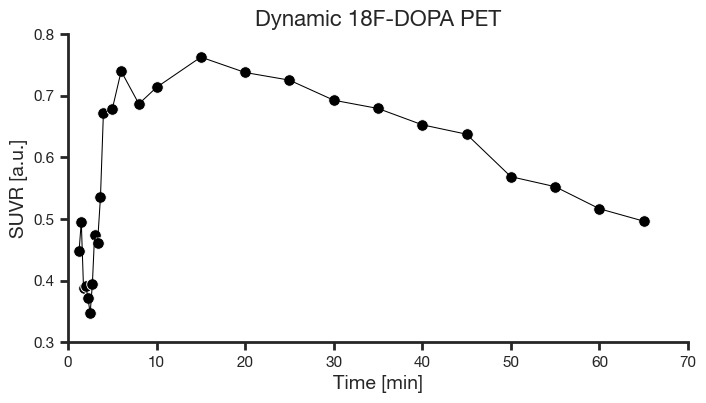

In [8]:
# Taken from sub-016, session-1 DOPA LONG

values = [0.447759992,
0.495647586,
0.388869978,
0.391590671,
0.372374834,
0.346814163,
0.394057007,
0.473445147,
0.460487215,
0.53594311,
0.672943871,
0.67851889,
0.740089093,
0.686973477,
0.713797051,
0.762911016,
0.737911725,
0.725499423,
0.692930099,
0.679517551,
0.652993337,
0.637736533,
0.56880337,
0.55255976,
0.516714269,
0.496590927,
]

seconds = [75,
90,
105,
120,
135,
150,
165,
180,
200,
220,
240,
300,
360,
480,
600,
900,
1200,
1500,
1800,
2100,
2400,
2700,
3000,
3300,
3600,
3900]

minutes = [x / 60 for x in seconds]


fig = plt.figure(figsize=(8, 4))
#ax = sns.lineplot(x=minutes, y=values, color=(253/255, 151/255, 31/255), linewidth=1)
ax = sns.scatterplot(x=minutes, y=values, color='black', s=70)  # s controls dot size
ax = sns.lineplot(x=minutes, y=values, color='black', linewidth=0.75)  # s controls dot size
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
sns.despine()  # Adjust spines
plt.title(f'Dynamic 18F-DOPA PET',fontsize = 16, weight = 'bold')
plt.xlabel('Time [min]', fontsize = 14)
plt.ylabel('SUVR [a.u.]', fontsize = 14)
plt.ylim(0.3,0.8)
plt.xlim(0,70)

# Save the figure -------
#image_path = os.path.join(outDir, f'Full_PET_timecourse.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Full_PET_timecourse.svg')
#fig.savefig(image_path_svg)

# Panel 6A - bottom


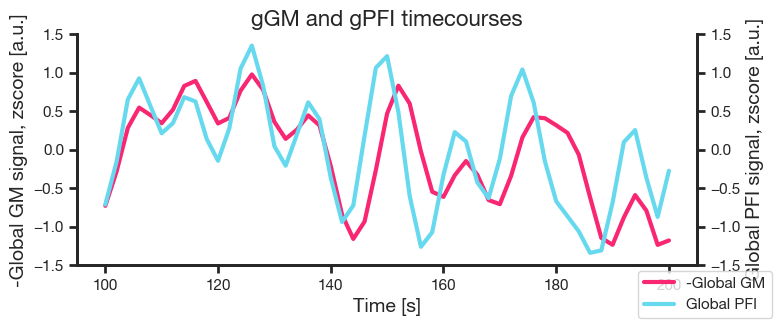

In [9]:
# Create the single subject timecourse - LONG

# Read the excel file into a dataframe
rest_timecourse = all_timeseries_Panel_A

subject_row = rest_timecourse[rest_timecourse['subID'] == 'sub-006-1']
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject

#print(wake_timecourse)

rest_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
rest_timecourse_dataframe = rest_timecourse.iloc[[subject_index]]
#print(rest_timecourse_dataframe)
# Print to check
#print(wake_timecourse)

# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("gm_tc")]
pfi_tc_columns = [col for col in rest_timecourse_dataframe.columns if col.startswith("pfi_tc")]

#print(len(gm_tc_columns))
# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([rest_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)
gm_values = stats.zscore(gm_values)
pfi_values = pd.concat([rest_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)
pfi_values = stats.zscore(pfi_values)
#print(gm_values)
#gm_values_z = pd.Series(stats.zscore(gm_values))
#pfi_values_z = pd.Series(stats.zscore(pfi_values), index=pfi_values.index)



rest_timecourse_new_one = pd.DataFrame()
rest_timecourse_new_one['timepoints'] = ((pd.Series(range(1, len(gm_values) + 1))) * 2) + 5*2 # This is the rest TR
rest_timecourse_new_one['global_gm'] = -gm_values
rest_timecourse_new_one['global_pfi'] = pfi_values

rest_timecourse_new_one_short = rest_timecourse_new_one[(rest_timecourse_new_one['timepoints'] >= 100) & (rest_timecourse_new_one['timepoints'] <= 200)]

fig,ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=rest_timecourse_new_one_short, ax=ax1, label='-Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=rest_timecourse_new_one_short, ax=ax2, label='Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)
#sns.lineplot(x="timepoints", y='tc', data=Subject_short[Subject_short['Parameters'] == "posterior PFI"], ax=ax2, label='Posterior PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)

# Flip ax1 values
#ax1.set_ylim(ax1.get_ylim()[::-1])

# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-Global GM signal, zscore [a.u.]', fontsize=14)
ax2.set_ylabel('Global PFI signal, zscore [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)
ax2.tick_params(axis='y')

plt.title(f'gGM and gPFI timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)

# Save the figure -------
#image_path = os.path.join(outDir, f'Rest_timecourse_Fig_5.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Rest_timecourse_Fig_5.svg')
#fig.savefig(image_path_svg)



# Panel 6B

8
tc    1.698002e-12
dtype: float64
tc    1.698002e-12
dtype: float64
10273.0
7
         tc
0  0.765056
1  0.671723
2  0.719623
3  0.629263
4  0.640329
5  0.576397
6  0.539217
7  0.488265
8  0.481046
9  0.462483
3
             tc
0    -81.392141
1    -34.735208
2     27.383429
3    -21.176654
4     -2.039160
5    -83.457179
6     12.527071
7     45.571632
8    -35.449784
9      0.502315
10  -112.241278
11     6.867012
12   -28.213579
13    19.000811
14    47.271539
15    87.457752
16     5.831120
17   -56.394289
18    93.875235
19   -20.672371
20   -39.773091
21   100.120490
22    48.570114
23   -86.597097
24   -63.956302
25    28.132111
26    42.530188
27   -38.528169
28   -32.280938
29    17.656234
30   -23.249257
31   -45.950841
32   -69.073028
33   -20.598215
34   -60.010661
35   -47.625743
36   -41.827949
37    47.918440
38   -27.080843
39   -22.037267
40   -22.041493
41    14.435475
42   -52.375441
43   -51.303890
44   -43.903187
45   -15.974391
46   -51.397739
47    -3.339186
48

(0.4, 0.9)

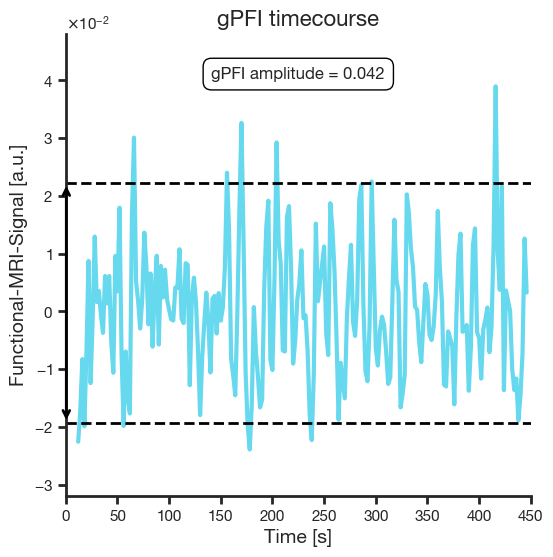

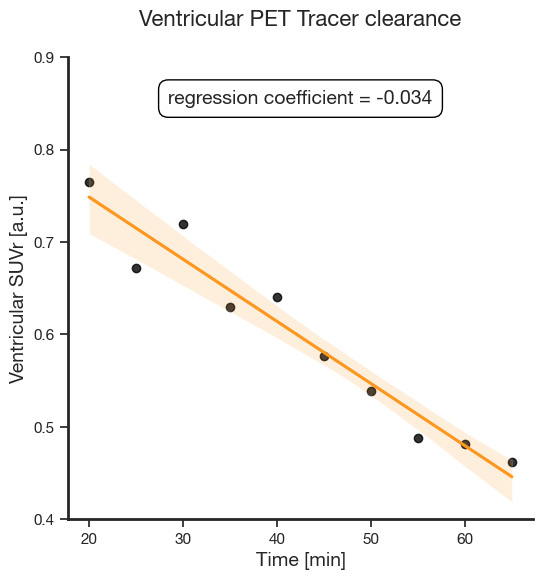

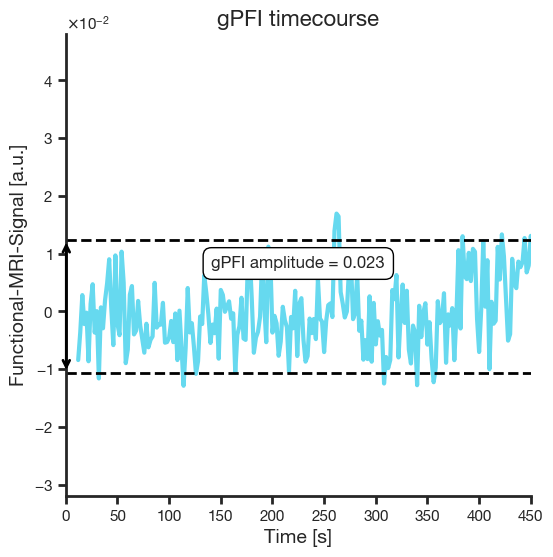

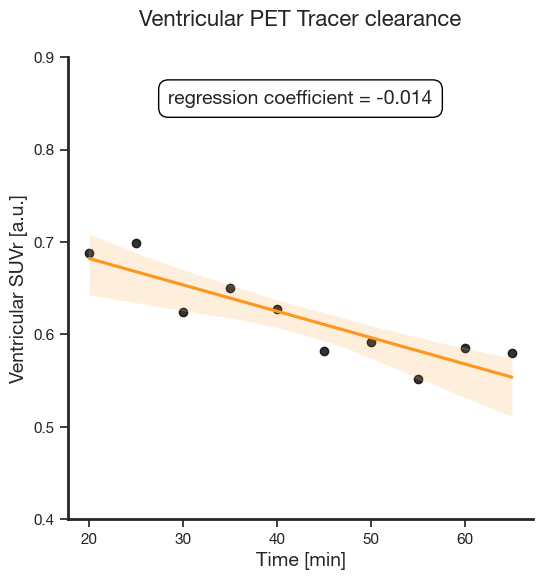

In [ ]:
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Control when to switch to scientific



# Read into a dataframe
subject_timecourse = all_timeseries
subject_timecourse_undetrended = all_timeseries_undetrended
subject_timecourse_pet = pet_LONG
#print(subject_timecourse)


# Extract columns that start with 'occipital_tc_'
pfi_columns = [col for col in subject_timecourse.columns if col.startswith('pfi_tc')] #startswith('PFI_band_timeseries_')
pfi_columns_undetrended = [col for col in subject_timecourse_undetrended.columns if col.startswith('pfi_tc')] #startswith('PFI_band_timeseries_')
pet_columns = [col for col in subject_timecourse_pet.columns if col.startswith('ventricular_tc')] #startswith('PFI_band_timeseries_')

#-----------------------------------------------------------------------------------------------


# Specify the index of the subject you are interested in
subject_row = subject_timecourse[subject_timecourse['subID'] == 'sub-009-1']
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject
print(subject_index)

# Extract the timecourses for the specific subject
timecourses_pfi = subject_timecourse.loc[subject_index, pfi_columns].values.tolist()
# Filter out NaN values from the list
timecourses_pfi = [x for x in timecourses_pfi if not pd.isna(x)]
#timecourses_pfi = stats.zscore(timecourses_pfi)
timecourses_pfi_df = pd.DataFrame({'tc': timecourses_pfi})
#print(timecourses_pfi_df)

#----
# Specify the index of the subject you are interested in
subject_row_undetrended = subject_timecourse_undetrended[subject_timecourse_undetrended['subID'] == 'sub-009-1']
subject_index_undetrended = subject_row_undetrended.index[0]  # Change this to the specific row index of your subject
#print(subject_index_undetrended)

# Extract the timecourses for the specific subject
timecourses_pfi_undetrended = subject_timecourse_undetrended.loc[subject_index_undetrended, pfi_columns_undetrended].values.tolist()
# Filter out NaN values from the list
timecourses_pfi_undetrended = [x for x in timecourses_pfi_undetrended if not pd.isna(x)]
#timecourses_pfi = stats.zscore(timecourses_pfi)
timecourses_pfi_df_undetrended = pd.DataFrame({'tc': timecourses_pfi_undetrended})
#print(timecourses_pfi_df_undetrended)

print(timecourses_pfi_df.mean())
print(timecourses_pfi_df_undetrended.mean())


# Generate the ranges
range_pfi = range(1, len(timecourses_pfi) + 1)


# Convert ranges to Series for concatenation
range_pfi_series = pd.Series(range_pfi)


# Calculate mean out of data
Subject = pd.DataFrame()    
Subject['tc'] = timecourses_pfi_df
percentile_97_5 = Subject['tc'].quantile(0.975)
percentile_2_5 = Subject['tc'].quantile(0.025)
amplitude = (percentile_97_5 - percentile_2_5)
timecourses_pfi_undetrended_mean_calc = 1.0273e4  # Taken from Analysis script correlate_ventricle_border_global_bold_script

print(timecourses_pfi_undetrended_mean_calc)

# Create a new DataFrame with a single column for the specific subject's timecourses
Subject['tc'] = timecourses_pfi_df/timecourses_pfi_undetrended_mean_calc
Subject['timepoints'] = range_pfi_series
Subject['timepoints'] = (Subject['timepoints'] * 2) + 5 * 2 # See if I need to do this! 
#Subject_categorical = [0] * len(timecourses_pfi_df)
#Subject['variables_categorical'] = Subject_categorical
#Subject['Parameters'] = Subject['variables_categorical'].apply(lambda x: "cccipital GM" if x == 0 else "posterior TFI")

# Display the new DataFrame
#print(Subject)
#Subject_short = Subject[(Subject['timepoints'] >= 78) & (Subject['timepoints'] <= 178)]


fig = plt.figure(figsize=(6, 6)) # was 16,8 for Figure 1
ax = sns.lineplot(x="timepoints",y='tc',data=Subject, color=(102/255, 217/255, 239/255), linewidth=3)

ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed



# Compute the 2.5th and 97.5th percentiles
percentile_97_5 = Subject['tc'].quantile(0.975)
percentile_2_5 = Subject['tc'].quantile(0.025)
amplitude = (percentile_97_5 - percentile_2_5)
rounded_amplitude = round(amplitude,3)

# Draw horizontal dashed lines at the percentiles
ax.axhline(y=percentile_97_5, linestyle='--', color='black', linewidth=2)
ax.axhline(y=percentile_2_5, linestyle='--', color='black', linewidth=2)

# Add arrow and label between the lines
mid_y = (percentile_97_5 + percentile_2_5) / 2
ax.annotate('', xy=(0.5, percentile_2_5), xytext=(0.5, percentile_97_5),
            arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))
#ax.annotate(
#    'amplitude',
#    xy=(50, mid_y),          # Arrow start point
#    xytext=(50, mid_y - 10), # Text location
#    arrowprops=dict(facecolor='black', arrowstyle='<->'),
#    ha='center'              # Horizontal alignment
#)
ax.yaxis.set_major_formatter(formatter)

sns.despine()  # Adjust spines
plt.title(f'gPFI timecourse',fontsize = 16, weight = 'bold')
plt.xlabel('Time [s]', fontsize = 14)
plt.ylabel('Functional-MRI-Signal [a.u.]', fontsize = 14)
plt.text(0.5, 0.93, f"gPFI amplitude = {rounded_amplitude}", fontsize=12, ha='center',va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.xlim(0, 450) # Set the y limit just like the one from the other plot, so the difference is directly observable
plt.ylim(-0.032, 0.048)

# Save the figure -------
#image_path = os.path.join(outDir, f'PFI_timecourse_Sub-09-1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'PFI_timecourse_Sub-09-1.svg')
#fig.savefig(image_path_svg)


#-------------------------------
# Create the Regression Plot
# Specify the index of the subject you are interested in
subject_row_pet = subject_timecourse_pet[subject_timecourse_pet['subID'] == 'sub-009-1'] # was 9 before
subject_index_pet = subject_row_pet.index[0]  # Change this to the specific row index of your subject
print(subject_index_pet)

# Extract the timecourses for the specific subject
timecourses_pet = subject_timecourse_pet.loc[subject_index_pet, pet_columns].values.tolist()
# Filter out NaN values from the list
timecourses_pet = [x for x in timecourses_pet if not pd.isna(x)]
#timecourses_pfi = stats.zscore(timecourses_pfi)
timecourses_pet_df = pd.DataFrame({'tc': timecourses_pet})
print(timecourses_pet_df)

# Generate the ranges
range_pet = range(1, len(timecourses_pet) + 1)


# Convert ranges to Series for concatenation
range_pet_series = pd.Series(range_pet)

Regression = pd.DataFrame()
Regression['timepoints'] = list(range(20, 66, 5))
Regression['value_decrease'] = timecourses_pet


fig = plt.figure(figsize=(6, 6))
corr_plot = sns.regplot(data=Regression, x='timepoints',y='value_decrease', scatter_kws={'color': 'black'}, line_kws={'color': (253/255, 151/255, 31/255)})
sns.despine()
plt.title('Ventricular PET Tracer clearance', weight='bold', fontsize=16, y=1.05)
plt.xlabel('Time [min]', fontsize=14)
plt.ylabel('Ventricular SUVr [a.u.]', fontsize=14)

#This is the regression coefficient
regression_coefficient = -0.0336
# Round to three decimal places
rounded_coefficient = round(regression_coefficient, 3)

plt.text(0.5, 0.93, f"regression coefficient = {rounded_coefficient}", fontsize=14, ha='center', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.ylim(0.4, 0.9) # Set the y limit just like the one from the other plot, so the difference is directly observable

# Save the figure -------
#image_path = os.path.join(outDir, f'Exemplary_regression_sub-09_ses-1.png')
#fig.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Exemplary_regression_sub-09_ses-1.svg')
#fig.savefig(image_path_svg)



#------------------------------------------------------------



# Specify the index of the subject you are interested in
subject_row = subject_timecourse[subject_timecourse['subID'] == 'sub-004-1']
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject
print(subject_index)

# Extract the timecourses for the specific subject
timecourses_pfi = subject_timecourse.loc[subject_index, pfi_columns].values.tolist()
# Filter out NaN values from the list
timecourses_pfi = [x for x in timecourses_pfi if not pd.isna(x)]
#timecourses_pfi = stats.zscore(timecourses_pfi)
timecourses_pfi_df = pd.DataFrame({'tc': timecourses_pfi})
print(timecourses_pfi_df)

#----
# Specify the index of the subject you are interested in
subject_row_undetrended = subject_timecourse_undetrended[subject_timecourse_undetrended['subID'] == 'sub-004-1']
subject_index_undetrended = subject_row_undetrended.index[0]  # Change this to the specific row index of your subject
print(subject_index_undetrended)

# Extract the timecourses for the specific subject
timecourses_pfi_undetrended = subject_timecourse_undetrended.loc[subject_index_undetrended, pfi_columns_undetrended].values.tolist()
# Filter out NaN values from the list
timecourses_pfi_undetrended = [x for x in timecourses_pfi_undetrended if not pd.isna(x)]
#timecourses_pfi = stats.zscore(timecourses_pfi)
timecourses_pfi_df_undetrended = pd.DataFrame({'tc': timecourses_pfi_undetrended})
print(timecourses_pfi_df_undetrended)


# Generate the ranges
range_pfi = range(1, len(timecourses_pfi) + 1)


# Convert ranges to Series for concatenation
range_pfi_series = pd.Series(range_pfi)

# Calculate mean out of data
Subject = pd.DataFrame()    
Subject['tc'] = timecourses_pfi_df
percentile_97_5 = Subject['tc'].quantile(0.975)
percentile_2_5 = Subject['tc'].quantile(0.025)
amplitude = (percentile_97_5 - percentile_2_5)
#timecourses_pfi_undetrended_mean_calc = amplitude/0.0231992089551036
timecourses_pfi_undetrended_mean_calc =  9.6738e3 # Taken from Analysis script correlate_ventricle_border_global_bold_script

print(timecourses_pfi_undetrended_mean_calc)

# Create a new DataFrame with a single column for the specific subject's timecourses
Subject['tc'] = timecourses_pfi_df/timecourses_pfi_undetrended_mean_calc
#Subject['tc'] = detrend(Subject['tc'] / Subject['tc'].mean())  # normalize by mean
Subject['timepoints'] = range_pfi_series
Subject['timepoints'] = (Subject['timepoints'] * 2) + 5 * 2 # See if I need to do this!
#Subject_categorical = [0] * len(timecourses_pfi_df)
#Subject['variables_categorical'] = Subject_categorical
#Subject['Parameters'] = Subject['variables_categorical'].apply(lambda x: "Occipital GM" if x == 0 else "Posterior TFI")

# Display the new DataFrame
#print(Subject)
#Subject_short = Subject[(Subject['timepoints'] >= 78) & (Subject['timepoints'] <= 178)]


fig = plt.figure(figsize=(6, 6)) # was 16,8 for Figure 1
ax = sns.lineplot(x="timepoints",y='tc',data=Subject, color=(102/255, 217/255, 239/255), linewidth=3)

ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed



# Compute the 2.5th and 97.5th percentiles
percentile_97_5 = Subject['tc'].quantile(0.975)
percentile_2_5 = Subject['tc'].quantile(0.025)
amplitude = (percentile_97_5 - percentile_2_5)
rounded_amplitude = round(amplitude,3)

# Draw horizontal dashed lines at the percentiles
ax.axhline(y=percentile_97_5, linestyle='--', color='black', linewidth=2)
ax.axhline(y=percentile_2_5, linestyle='--', color='black', linewidth=2)

# Add arrow and label between the lines
mid_y = (percentile_97_5 + percentile_2_5) / 2
ax.annotate('', xy=(0.5, percentile_2_5), xytext=(0.5, percentile_97_5),
            arrowprops=dict(arrowstyle='<->', color='black', linewidth=2))
plt.text(0.5, 0.52, f"gPFI amplitude = {rounded_amplitude}", fontsize=12, ha='center',va = 'top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

#plt.annotate(
#    '',
#    xy=(50, mid_y),          # Arrow start point
#    xytext=(50, mid_y - 10), # Text location
#    arrowprops=dict(facecolor='black', arrowstyle='<->'),
#    ha='center')
ax.yaxis.set_major_formatter(formatter)
sns.despine()  # Adjust spines
plt.title(f'gPFI timecourse',fontsize = 16, weight = 'bold')
plt.xlim(0, 450)
plt.ylim(-0.032, 0.048)
plt.xlabel('Time [s]', fontsize = 14)
plt.ylabel('Functional-MRI-Signal [a.u.]', fontsize = 14)


# Save the figure -------
#image_path = os.path.join(outDir, f'PFI_timecourse_Sub-04-1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'PFI_timecourse_Sub-04-1.svg')
#fig.savefig(image_path_svg)


#-------------------------------
# Create the Regression Plot

# Create the Regression Plot
# Specify the index of the subject
subject_row_pet = subject_timecourse_pet[subject_timecourse_pet['subID'] == 'sub-004-1']
subject_index_pet = subject_row_pet.index[0]  # Change this to the specific row index of your subject
#print(subject_index_pet)

# Extract the timecourses for the specific subject
timecourses_pet = subject_timecourse_pet.loc[subject_index_pet, pet_columns].values.tolist()
# Filter out NaN values from the list
timecourses_pet = [x for x in timecourses_pet if not pd.isna(x)]

timecourses_pet_df = pd.DataFrame({'tc': timecourses_pet})
#print(timecourses_pet_df)

# Generate the ranges
range_pet = range(1, len(timecourses_pet) + 1)


# Convert ranges to Series for concatenation
range_pet_series = pd.Series(range_pet)

Regression = pd.DataFrame()
Regression['timepoints'] = list(range(20, 66, 5))
Regression['value_decrease'] = timecourses_pet


fig = plt.figure(figsize=(6, 6))
corr_plot = sns.regplot(data=Regression, x='timepoints',y='value_decrease', scatter_kws={'color': 'black'}, line_kws={'color': (253/255, 151/255, 31/255)})
sns.despine()
plt.title('Ventricular PET Tracer clearance', weight='bold', fontsize=16, y=1.05)
plt.xlabel('Time [min]', fontsize=14)
plt.ylabel('Ventricular SUVr [a.u.]', fontsize=14)

#This is the regression coefficient
regression_coefficient = -0.0143
# Round to three decimal places
rounded_coefficient = round(regression_coefficient, 3)

plt.text(0.5, 0.93, f"regression coefficient = {rounded_coefficient}", fontsize=14, ha='center', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.ylim(0.4, 0.9) # Set the y limit just like the one from the other plot, so the difference is directly observable

# Save the figure -------
#image_path = os.path.join(outDir, f'Exemplary_regression_sub-04_ses-1.png')
#fig.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Exemplary_regression_sub-04_ses-1.svg')
#fig.savefig(image_path_svg)


# Prep the dataframes - Turn the amplitudes in percent

In [11]:
hc_bimodal_first_session['gm_amplitude_normalized'] = hc_bimodal_first_session['gm_amplitude_normalized']*100
hc_bimodal_first_session['partial_volume_effect_amplitude_normalized'] = hc_bimodal_first_session['partial_volume_effect_amplitude_normalized']*100
hc_bimodal_first_session['partial_volume_effect_confidence_interval_normalized'] = hc_bimodal_first_session['partial_volume_effect_confidence_interval_normalized']*100
hc_bimodal['ventricular_slope'] = hc_bimodal['ventricular_slope'] * 300
hc_bimodal_first_session['ventricular_slope'] = hc_bimodal_first_session['ventricular_slope'] * 300

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_2618/1730113495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_bimodal['ventricular_slope'] = hc_bimodal['ventricular_slope'] * 300


# Panel 6C

<Figure size 800x600 with 0 Axes>

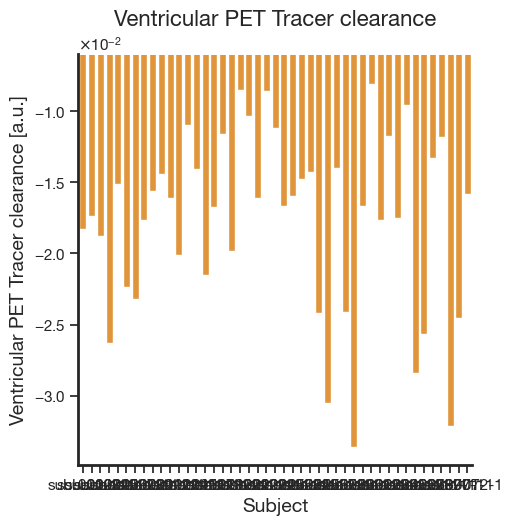

In [12]:
# Figure 5C
fig = plt.figure(figsize=(8,6))
pet_plot = sns.catplot(data=hc_bimodal_first_session, x='subID',y='ventricular_slope',kind='bar',errorbar='sd',color=(253/255, 151/255, 31/255))
sns.despine()
plt.title('Ventricular PET Tracer clearance', weight='bold', fontsize=16, y=1.05)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Ventricular PET Tracer clearance [a.u.]', fontsize=14)
plt.ylim(-0.0349,-0.006)
#ax = plt.gca()
ax = pet_plot.ax
ax.yaxis.set_major_formatter(formatter)

# Save the figure -------
#image_path = os.path.join(outDir, f'PET slopes of all subjects.png')
#pet_plot.figure.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'PET slopes of all subjects.svg')
#pet_plot.figure.savefig(image_path_svg)

# Panel 6D

    Unnamed: 0_x      subID  partial_volume_effect_amplitude_normalized  \
0              0  sub-001-1                                    7.223538   
1              1  sub-002-1                                    2.251812   
2              2  sub-003-1                                    6.038248   
3              3  sub-004-1                                    5.539710   
4              4  sub-005-1                                    4.466892   
5              5  sub-006-1                                    5.604876   
6              6  sub-007-1                                    7.786271   
7              7  sub-008-1                                    7.594621   
8              8  sub-009-1                                    7.510269   
9              9  sub-011-1                                    2.894223   
10            10  sub-012-1                                    3.250021   
11            11  sub-013-1                                    6.914111   
12            12  sub-014

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_2618/879199280.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_bimodal['subID'] = hc_bimodal['subID'].astype(str)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_2618/879199280.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_bimodal['subID_covar'] = hc_bimodal['subID'].str.rsplit('-', n=1).str[0]
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_2618/879199280.py:32: SettingWithCopyWarning: 
A value is trying to b

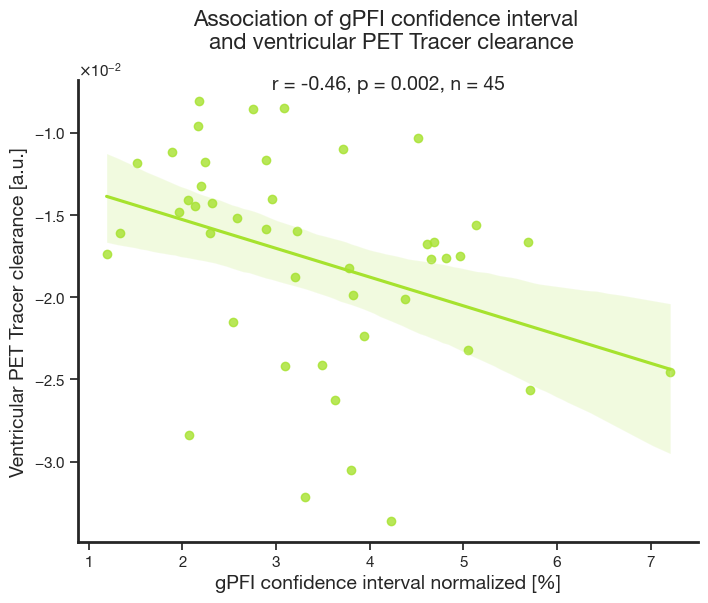

In [14]:
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Control when to switch to scientific

#ax.yaxis.set_major_formatter(formatter)


# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(hc_bimodal_first_session)


# 2. Association with PET - Using normalized Amplitude

fig = plt.figure(figsize=(8,6))
corr_plot = sns.regplot(data=hc_bimodal_first_session, x='partial_volume_effect_confidence_interval_normalized',y='ventricular_slope', color=(166/255, 226/255, 46/255))
sns.despine()
plt.title('Association of gPFI confidence interval \n and ventricular PET Tracer clearance', weight='bold', fontsize=16, y=1.05)
plt.xlabel('gPFI confidence interval normalized [%]', fontsize=14)
plt.ylabel('Ventricular PET Tracer clearance [a.u.]', fontsize=14)

corr_plot.yaxis.set_major_formatter(formatter)

# Add the correlation values
corr = pg.corr(hc_bimodal_first_session['partial_volume_effect_confidence_interval_normalized'], hc_bimodal_first_session['ventricular_slope'], method='spearman')
#print(corr)

hc_bimodal['subID'] = hc_bimodal['subID'].astype(str)
hc_bimodal['subID_covar'] = hc_bimodal['subID'].str.rsplit('-', n=1).str[0]
hc_bimodal['subID_covar'] = hc_bimodal['subID_covar'].astype('category').cat.codes




p_value = corr['p-val'].values[0]
if p_value < 0.001:
    p_str = 'p < 0.001'
else:
    p_str = f'p = {p_value:.3f}'

plt.text(0.5, 0.98, f"r = {corr['r'].values[0]:.2f}, {p_str}, n = {corr['n'].values[0]}", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Association of normalized PFI and CSF egress.png')
#fig.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Association of normalized PFI and CSF egress.svg')
#fig.savefig(image_path_svg)



print("Here now min max, mean und sd aus dem slope vektor")
print(min(hc_bimodal_first_session['ventricular_slope']))
print(max(hc_bimodal_first_session['ventricular_slope']))
print(hc_bimodal_first_session['ventricular_slope'].mean())
print(hc_bimodal_first_session['ventricular_slope'].std())
